In [ ]:
pip install nltk


In [1]:
#libraries
import requests
import nltk
from nltk.tokenize import word_tokenize
import re
import pandas as pd
import numpy as np
from collections import Counter
import random

# Download NLTK word tokenizer if not already downloaded
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
pip install pdfplumber


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 373.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 58.6 MB/s eta 0:00:00


In [ ]:
import pdfplumber

# Open the downloaded PDF
with pdfplumber.open('book.pdf.pdf') as pdf:
    full_text = ""
    for page in pdf.pages:
        full_text += page.extract_text()  # Extract text from each page

# Show the first 500 characters of the extracted text
print(full_text[:500])


AN IMPRINT OF PENGUIN RANDOM HOUSE LLC
375 Hudson Street
New York, New York 10014
Copyright © 2018 by James Clear
Penguin supports copyright. Copyright fuels creativity, encourages diverse voices, promotes free speech, and creates
a vibrant culture. Thank you for buying an authorized edition of this book and for complying with copyright laws by not
reproducing, scanning, or distributing any part of it in any form without permission. You are supporting writers and
allowing Penguin to continue to 


In [ ]:
# Step 1: Fetch the text from the URL
url = "https://www.gutenberg.org/cache/epub/2680/pg2680.txt"
response = requests.get(url)
response.raise_for_status()  # Check for successful response

In [ ]:
# Step 2: Tokenize the text into words
words = word_tokenize(full_text) #This is an NLTK function that splits the input text into individual tokens, typically words, by recognizing word boundaries (spaces, punctuation, etc.).


In [ ]:
clean_data = []
def is_only_letters(s):
    return s.isalpha()

for i in words:
  if is_only_letters(i)== True: #we're filtering out the punctuation, spaces and numbers and converting to lower case
    clean_data.append(i.lower())

In [ ]:
# Step 2: Define a window size (number of context words on each side)
window_size = 2

# Step 3: Initialize lists to store the input-output pairs
input_words = []
output_words = []

start_word = clean_data[2] #the middle element - starting point -  ensuring there are 2 words before and 2 words after
start_index=2

# Step 4: Generate the input-output pairs for skip-gram model, starting from 'start_word'
for i in range(start_index, len(clean_data)):
    target_word = clean_data[i]

    # Find the context words within the window size (2 before and 2 after)
    start_idx = max(i - window_size, 0)
    end_idx = min(i + window_size + 1, len(clean_data))

    # Add context words to input-output pairs, excluding the target word itself
    for j in range(start_idx, end_idx): #this will always be 3 more or less
        if i != j:
            input_words.append(target_word)
            output_words.append(clean_data[j])

In [ ]:
# Step 5: Store the input-output pairs in a DataFrame
skipgram_df = pd.DataFrame({
    'input': input_words,
    'output': output_words
})

# Display the first few rows
print(skipgram_df)

          input   output
0            of       an
1            of  imprint
2            of  penguin
3            of   random
4       penguin  imprint
...         ...      ...
298424       or    means
298425       or     heap
298426       or     pile
298427     pile     heap
298428     pile       or

[298429 rows x 2 columns]


In [ ]:
#intorducing negative samples

# Calculate word frequencies
word_freq = Counter(clean_data)#changed this from words

# Get vocabulary and apply 0.75 power to frequencies
vocab = list(word_freq.keys()) #vocab already doesn't have duplicates
freq_adjusted = np.array([word_freq[word]**0.75 for word in vocab])
prob_dist = freq_adjusted / freq_adjusted.sum()  # Normalize to create probabilities

# Number of negative samples per positive sample
num_neg_samples = 5

# Function to generate negative samples for each positive pair
def generate_negative_samples(input_word, output_word, num_samples):
    negative_words = []
    while len(negative_words) < num_samples:
        neg_sample = np.random.choice(vocab, p=prob_dist)
        if neg_sample != output_word and neg_sample not in negative_words: #ensure negative word isn't a true word or another negative word (no duplicates)
          negative_words.append(neg_sample)
    return negative_words


In [ ]:
# Add negative samples to your DataFrame as described before
neg_samples = {'input': [], 'output': [], 'label': []}
for _, row in skipgram_df.iterrows(): #this isn't optimized - can vectorize it
    input_word = row['input']
    output_word = row['output']

    # Add positive sample
    neg_samples['input'].append(input_word)
    neg_samples['output'].append(output_word)
    neg_samples['label'].append(1)  # Positive label

    # Generate negative samples
    for neg_word in generate_negative_samples(input_word, output_word, num_neg_samples):
        neg_samples['input'].append(input_word)
        neg_samples['output'].append(neg_word)
        neg_samples['label'].append(0)  # Negative label

# Convert to DataFrame
final_df = pd.DataFrame(neg_samples)
print(final_df)

        input      output  label
0          of          an      1
1          of           i      0
2          of         was      0
3          of     finance      0
4          of     pattern      0
...       ...         ...    ...
1790569  pile        mean      0
1790570  pile     product      0
1790571  pile  discovered      0
1790572  pile         the      0
1790573  pile        loop      0

[1790574 rows x 3 columns]


In [ ]:
vocab_size = len(clean_data)  # Assuming clean_data is your vocabulary list
embedding_dim = 300 #my choice
embeddings_matrix = np.random.rand(vocab_size, embedding_dim)
context_matrix = np.random.rand(vocab_size, embedding_dim)

In [ ]:
#store the index so that every word has a knwon position in the embeddings and context matrices
vocab_lookup = {word: index for index, word in enumerate(clean_data)}

In [ ]:
# Function to calculate cosine similarity
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2) if norm_vec1 != 0 and norm_vec2 != 0 else 0

# Calculate cosine similarity for each row and append as a new column
cosine_similarities = []
for _, row in final_df.iterrows():
    input_word = row['input']
    output_word = row['output']

    # Get indices for input and output words
    input_index = vocab_lookup[input_word]
    output_index = vocab_lookup[output_word]

    # Get corresponding vectors from embeddings and context matrices
    input_vector = embeddings_matrix[input_index]
    output_vector = context_matrix[output_index]

    # Calculate cosine similarity and append
    similarity = cosine_similarity(input_vector, output_vector)
    cosine_similarities.append(similarity)

# Add cosine similarity as a new column
final_df['cosine_similarity'] = cosine_similarities
print(final_df)

In [ ]:
def sigmoid(x): #cosine values are already between 0 and 1 but sigmoid can help collapse the range if there are any values outside the 0,1 range
    return 1 / (1 + np.exp(-x))

# Apply the sigmoid function to the cosine_similarity column
final_df['sigmoid_similarity'] = final_df['cosine_similarity'].apply(sigmoid)

print(final_df)

      input     output  label  cosine_similarity  sigmoid_similarity
0     ebook    project      1           0.731081            0.675043
1     ebook      carry      0           0.740381            0.677079
2     ebook  available      0           0.750745            0.679341
3     ebook    through      0           0.768460            0.683188
4     ebook         to      0           0.745440            0.678184
...     ...        ...    ...                ...                 ...
6001    the        but      0           0.719639            0.672527
6002    the      small      0           0.768233            0.683139
6003    the         iv      0           0.772582            0.684079
6004    the       true      0           0.730465            0.674907
6005    the         in      0           0.769506            0.683414

[6006 rows x 5 columns]


In [ ]:
def binary_cross_entropy(y_true, y_pred):
    # Clip probabilities to avoid log(0) errors
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
    return - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# Apply the binary cross-entropy function to each row
#vectorizing
final_df['entropy_loss'] = - (final_df['label'] * np.log(final_df['sigmoid_similarity']) + (1 - final_df['label']) * np.log(1 - final_df['sigmoid_similarity']))

In [ ]:
final_df

,input,output,label,cosine_similarity,sigmoid_similarity,entropy_loss
0,ebook,project,1,0.731081,0.675043,0.392980
1,ebook,carry,0,0.740381,0.677079,1.130348
2,ebook,available,0,0.750745,0.679341,1.137377
3,ebook,through,0,0.768460,0.683188,1.149446
4,ebook,to,0,0.745440,0.678184,1.133776
...,...,...,...,...,...,...
6001,the,but,0,0.719639,0.672527,1.116351
6002,the,small,0,0.768233,0.683139,1.149291
6003,the,iv,0,0.772582,0.684079,1.152264
6004,the,true,0,0.730465,0.674907,1.123645


In [ ]:
  #seperate function# Example for updating one embedding
def update_single_embedding(input_index, output_index, label, pred, input_vector, output_vector, learning_rate):
    # Calculate the error (gradient of the loss function)
    error = label - pred  # Error = true label - predicted probability (sigmoid output)

    # Compute gradients for a single embedding
    grad_input = error * output_vector  # Gradient for input vector
    grad_output = error * input_vector  # Gradient for output vector

    # Update the embeddings matrices using the learning rate and gradients
    embeddings_matrix[input_index] += learning_rate * grad_input  # Update input embedding
    context_matrix[output_index] += learning_rate * grad_output  # Update output embedding


In [ ]:
# Define your training parameters
num_samples = len(clean_data)  # Total number of samples in your dataset
batch_size = 1000  # Number of samples processed in each step
num_epochs = 10  # Number of times to iterate over the entire dataset

# Calculate steps per epoch
steps_per_epoch = num_samples // batch_size  # Integer division

# Calculate the total number of steps (num_steps)
num_steps = steps_per_epoch * num_epochs
print("Total training steps:", num_steps)


Total training steps: 740


In [ ]:
# vectorized version

# Initialize learning rate and decay parameters
initial_learning_rate = 0.01
decay_rate = 0.95  # Exponential decay rate
decay_steps = 1000  # Decay every 1,000 updates

# Define the update function for embeddings
def update_embeddings_matrix(input_indices, output_indices, labels, preds, input_vectors, output_vectors, learning_rate):
    # Calculate the errors (gradients of the loss function)
    errors = labels - preds  # Error = true label - predicted probability (sigmoid output)

    # Compute gradients using broadcasting
    grad_input = errors[:, np.newaxis] * output_vectors  # (num_samples, embedding_dim)
    grad_output = errors[:, np.newaxis] * input_vectors  # (num_samples, embedding_dim)

    # Update the embeddings matrices using the learning rate and gradients
    np.add.at(embeddings_matrix, input_indices, learning_rate * grad_input)  # Update input embeddings
    np.add.at(context_matrix, output_indices, learning_rate * grad_output)  # Update output embeddings

# Function to update the learning rate based on exponential decay
def update_learning_rate(step, learning_rate, decay_rate, decay_steps):
    return learning_rate * (decay_rate ** (step / decay_steps))

# Example training loop
for step in range(1, num_steps + 1):
    # Update learning rate using exponential decay
    learning_rate = update_learning_rate(step, initial_learning_rate, decay_rate, decay_steps)

    # Extract data from final_df (batch operations)
    input_words = final_df['input'].values
    output_words = final_df['output'].values
    labels = final_df['label'].values
    preds = final_df['sigmoid_similarity'].values

    # Convert words to indices using vocab_lookup
    input_indices = np.array([vocab_lookup[word] for word in input_words])
    output_indices = np.array([vocab_lookup[word] for word in output_words])

    # Retrieve the input and output vectors from the embedding matrices
    input_vectors = embeddings_matrix[input_indices]
    output_vectors = context_matrix[output_indices]

    # Update embeddings using the current learning rate
    update_embeddings_matrix(input_indices, output_indices, labels, preds, input_vectors, output_vectors, learning_rate)


In [ ]:
# Initialize list to store average loss per epoch
loss_history = []
epochs=num_epochs #10
# Training loop over epochs
for epoch in range(epochs):
    final_df = final_df.sample(frac=1).reset_index(drop=True)  # Shuffle data
    total_loss = 0  # Initialize loss for this epoch

    # Loop through each row in the DataFrame
    for _, row in final_df.iterrows():
        input_word = row['input']
        output_word = row['output']
        label = row['label']

        # Look up indices for input and output words
        input_index = vocab_lookup[input_word]
        output_index = vocab_lookup[output_word]

        # Retrieve embedding vectors
        input_vector = embeddings_matrix[input_index]
        output_vector = context_matrix[output_index]

        # Calculate the dot product
        dot_product = cosine_similarity(input_vector, output_vector) #calcualte again becasue the embeddings vectors do get updated, and I only calculated cosine and other once

        # Calculate the prediction using the sigmoid function
        pred = sigmoid(dot_product)

        # Calculate the binary cross-entropy loss
        loss = binary_cross_entropy(label, pred)
        total_loss += loss  # Accumulate loss for monitoring - this is the entire goal of this block of code

        # Update embeddings
        update_single_embedding(input_index, output_index, label, pred, input_vector, output_vector,learning_rate)

    # Calculate and store the average loss for this epoch
    average_loss = total_loss / len(final_df)
    loss_history.append(average_loss)  # Store the average loss
    print(f"Epoch {epoch + 1}/{epochs} - Average Loss: {average_loss:.4f}")


Epoch 1/10 - Average Loss: 0.4138
Epoch 2/10 - Average Loss: 0.4147
Epoch 3/10 - Average Loss: 0.4125
Epoch 4/10 - Average Loss: 0.4138
Epoch 5/10 - Average Loss: 0.4117
Epoch 6/10 - Average Loss: 0.4155
Epoch 7/10 - Average Loss: 0.4187
Epoch 8/10 - Average Loss: 0.4158
Epoch 9/10 - Average Loss: 0.4228
Epoch 10/10 - Average Loss: 0.4247


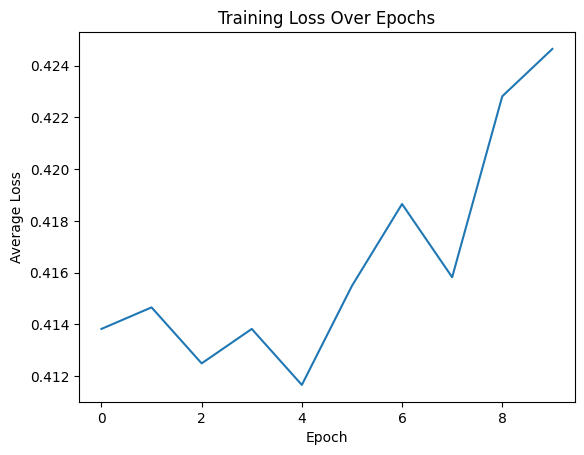

In [ ]:
import matplotlib.pyplot as plt

# Plotting the loss history
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Over Epochs')
plt.show()


In [ ]:
##prediction
#given a word, predict the word that is most similar to it
def cosine_similarity(vec1, vec2):
    """Calculate cosine similarity between two vectors."""
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def predict_word(input_word, embeddings_matrix, context_matrix, vocab_lookup):
    """
    Predict the output word based on the input word's embedding.
    Uses cosine similarity to find the most similar word in the context matrix.
    """
    if input_word not in vocab_lookup:
        return None, None  # Return None if the input word is not in vocabulary

    input_index = vocab_lookup[input_word]
    input_vector = embeddings_matrix[input_index]

    # Find the most similar word in the context matrix
    max_similarity = -1
    predicted_word = None

    for word, index in vocab_lookup.items():
        output_vector = context_matrix[index]
        similarity = cosine_similarity(input_vector, output_vector)

        if similarity > max_similarity:
            max_similarity = similarity
            predicted_word = word

    return predicted_word, max_similarity

# Example input words
input_words = ['king', 'queen', 'apple', 'paris', 'unknown_word']  # Add your input words

# Create a DataFrame to store the results
results = {
    'Input Word': [],
    'Predicted Word': [],
    'Cosine Similarity': [],
    'Actual Word (if available)': []  # Optional: actual known predicted words
}

# Dictionary of expected predictions (this is just an example; use your own dataset or manually specify)
# Here we define what the expected predictions should be for certain input words
expected_predictions = {
    'king': 'queen',
    'queen': 'king',
    'apple': 'fruit',  # For example, if you know "apple" is related to "fruit"
    'paris': 'france'
}

# Predict and store results
for input_word in input_words:
    predicted_word, similarity = predict_word(input_word, embeddings_matrix, context_matrix, vocab_lookup)
    results['Input Word'].append(input_word)
    results['Predicted Word'].append(predicted_word if predicted_word else "N/A")
    results['Cosine Similarity'].append(similarity if similarity else "N/A")

    # Check against expected predictions (optional)
    if input_word in expected_predictions:
        actual_word = expected_predictions[input_word]
    else:
        actual_word = "N/A"

    results['Actual Word (if available)'].append(actual_word)

# Convert results to a DataFrame
output_table = pd.DataFrame(results)
print(output_table)

# If you want to calculate accuracy (for known predictions):
correct_predictions = sum([1 for i, row in output_table.iterrows() if row['Predicted Word'] == row['Actual Word (if available)']])
total_predictions = len(output_table)

accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy:.2f}")


     Input Word Predicted Word Cosine Similarity Actual Word (if available)
0          king          parts               1.0                      queen
1         queen            N/A               N/A                       king
2         apple            N/A               N/A                      fruit
3         paris            N/A               N/A                     france
4  unknown_word            N/A               N/A                        N/A
Accuracy: 0.20


In [ ]:
#prediction: another evaluation method
#loading google's analogy dataset
import urllib.request

# URL for Google's analogy dataset
url = "https://raw.githubusercontent.com/tmikolov/word2vec/master/questions-words.txt"
filename = "questions-words.txt"

# Download the file
urllib.request.urlretrieve(url, filename)
print(f"Downloaded {filename}")


Downloaded questions-words.txt


In [ ]:
analogy_questions = []

with open(filename, 'r') as file:
    category = None
    for line in file:
        line = line.strip()

        # Check for category lines starting with ":"
        if line.startswith(":"):
            category = line[1:].strip()
            continue

        # Split line into words and append to the list as (word1, word2, word3, word4, category)
        words = line.split()
        if len(words) == 4:
            word1, word2, word3, word4 = words
            analogy_questions.append((word1, word2, word3, word4, category))

print(f"Loaded {len(analogy_questions)} analogy questions")


Loaded 19544 analogy questions


In [ ]:
def find_closest_word(result_vector, embeddings_matrix, vocab_lookup, exclude_words=None):
    """Find the word in the embeddings closest to the result_vector, excluding any specified words."""
    max_similarity = -1
    closest_word = None

    for word, index in vocab_lookup.items():
        # Exclude specific words if needed
        if exclude_words and word in exclude_words:
            continue

        # Get the embedding vector for the current word
        word_vector = embeddings_matrix[index]
        similarity = cosine_similarity(result_vector, word_vector)

        if similarity > max_similarity:
            max_similarity = similarity
            closest_word = word

    return closest_word

In [ ]:
# To track accuracy
correct = 0
total = len(analogy_questions)

for word1, word2, word3, target_word, category in analogy_questions:
    try:
        # Retrieve vectors and calculate the result
        index1, index2, index3 = vocab_lookup[word1], vocab_lookup[word2], vocab_lookup[word3]
        vec1, vec2, vec3 = embeddings_matrix[index1], embeddings_matrix[index2], embeddings_matrix[index3]

        # Calculate the result vector
        result_vector = vec1 - vec2 + vec3

        # Find the closest word
        predicted_word = find_closest_word(result_vector, embeddings_matrix, vocab_lookup, exclude_words={word1, word2, word3})

        # Check if the prediction is correct
        if predicted_word == target_word:
            correct += 1

        print(f"{word1} : {word2} :: {word3} : {predicted_word} (Target: {target_word})")

    except KeyError as e:
        # If any word is not in the vocabulary, skip the question
        print(f"Skipping analogy due to missing word: {e.args[0]}")

# Calculate accuracy
accuracy = correct / total * 100
print(f"Analogy Task Accuracy: {accuracy:.2f}%")

Streaming output truncated to the last 5000 lines.
Skipping analogy due to missing word: China
Skipping analogy due to missing word: China
Skipping analogy due to missing word: China
Skipping analogy due to missing word: China
Skipping analogy due to missing word: China
Skipping analogy due to missing word: China
Skipping analogy due to missing word: China
Skipping analogy due to missing word: China
Skipping analogy due to missing word: China
Skipping analogy due to missing word: China
Skipping analogy due to missing word: China
Skipping analogy due to missing word: China
Skipping analogy due to missing word: China
Skipping analogy due to missing word: China
Skipping analogy due to missing word: China
Skipping analogy due to missing word: China
Skipping analogy due to missing word: China
Skipping analogy due to missing word: China
Skipping analogy due to missing word: China
Skipping analogy due to missing word: China
Skipping analogy due to missing word: China
Skipping analogy due to m